## Modelo 03 XGBoost Regression

Como parte del bootcamp de Henry de Data Science se realiza un modelo para predecir el número de bicicletas.

### Exploración de datos

El objetivo de la primera parte del notebook es realizar una exploración de los datos del Dataset bike_train.xlsx

1. Librerías a usarse:

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb

2. Importamos los archivos como dataframes

In [2]:
bike_train = pd.read_excel('bike_train.xlsx')
bike_test = pd.read_excel('bike_test.xlsx')
bike_train.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
bike_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     11999 non-null  int64         
 1   dteday      11999 non-null  datetime64[ns]
 2   season      11999 non-null  int64         
 3   yr          11999 non-null  int64         
 4   mnth        11999 non-null  int64         
 5   hr          11999 non-null  int64         
 6   holiday     11999 non-null  int64         
 7   weekday     11999 non-null  int64         
 8   workingday  11999 non-null  int64         
 9   weathersit  11999 non-null  int64         
 10  temp        11999 non-null  float64       
 11  atemp       11999 non-null  float64       
 12  hum         11999 non-null  float64       
 13  windspeed   11999 non-null  float64       
 14  casual      11999 non-null  int64         
 15  registered  11999 non-null  int64         
 16  cnt         11999 non-

In [4]:
bike_test.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,12000,2012-05-20,2,1,5,4,0,0,0,1,0.52,0.5000,0.68,0.0896
1,12001,2012-05-20,2,1,5,5,0,0,0,1,0.50,0.4848,0.72,0.1045
2,12002,2012-05-20,2,1,5,6,0,0,0,1,0.50,0.4848,0.63,0.1343
3,12003,2012-05-20,2,1,5,7,0,0,0,1,0.52,0.5000,0.68,0.1940
4,12004,2012-05-20,2,1,5,8,0,0,0,1,0.56,0.5303,0.56,0.1642


3. Eliminamos las columnas que no servirían como input. Instant es un anterior index y dteday no lo vamos a requerir ya que no lo estamos trabajando como serie de tiempo

In [6]:
drop_columns = ['instant','dteday', 'casual', 'registered']
train = bike_train.drop(drop_columns, axis =1)
test = bike_test.drop(['instant','dteday'], axis =1)
train.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


3.1 Evaluamos las correlaciones lineales, nos quedamos con las variables con las que tiene mayor correlación y las que tienen correlación entre ellas

In [46]:
train.corr()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
season,1.000000,-0.446665,0.865268,-0.007610,-0.008928,-0.003688,0.012630,-0.009029,0.410790,0.413196,0.198937,-0.142924,0.111369
yr,-0.446665,1.000000,-0.488103,-0.003948,0.001039,-0.002714,0.001068,-0.006309,-0.198929,-0.190360,-0.141319,0.067356,0.156960
mnth,0.865268,-0.488103,1.000000,-0.007060,0.009372,0.014500,0.006441,-0.012239,0.353330,0.358541,0.201669,-0.147042,0.073431
hr,-0.007610,-0.003948,-0.007060,1.000000,0.000414,-0.004037,0.003454,-0.024003,0.139251,0.134633,-0.257202,0.130441,0.396698
holiday,-0.008928,0.001039,0.009372,0.000414,1.000000,-0.102503,-0.248601,-0.014707,-0.028519,-0.038005,-0.036672,0.022681,-0.030304
weekday,-0.003688,-0.002714,0.014500,-0.004037,-0.102503,1.000000,0.031057,0.017259,-0.010002,-0.009841,-0.025932,0.008447,0.022618
workingday,0.012630,0.001068,0.006441,0.003454,-0.248601,0.031057,1.000000,0.042202,0.062273,0.066305,0.022805,-0.002493,0.025132
weathersit,-0.009029,-0.006309,-0.012239,-0.024003,-0.014707,0.017259,0.042202,1.000000,-0.080149,-0.081386,0.430378,0.009195,-0.149848
temp,0.410790,-0.198929,0.353330,0.139251,-0.028519,-0.010002,0.062273,-0.080149,1.000000,0.991785,-0.019289,-0.013984,0.395743
atemp,0.413196,-0.190360,0.358541,0.134633,-0.038005,-0.009841,0.066305,-0.081386,0.991785,1.000000,-0.003669,-0.057619,0.395234


In [47]:
pd.crosstab(train['yr'], columns='cnt')

col_0,cnt
yr,
0,8645
1,3354


In [48]:
train.groupby('yr')['cnt'].mean()

yr
0    143.794448
1    196.743590
Name: cnt, dtype: float64

In [51]:
train.groupby('mnth')['cnt'].mean()

mnth
1      94.424773
2     112.865026
3     155.410726
4     187.260960
5     213.221761
6     199.322222
7     189.974462
8     186.991792
9     177.709902
10    166.232840
11    142.095967
12    117.844804
Name: cnt, dtype: float64

In [52]:
X = train.drop('cnt',axis=1)
y =train['cnt']

In [53]:
import statsmodels.api as sm

In [54]:
X_constant = sm.add_constant(X)
lin_reg =sm.OLS(y, X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     603.5
Date:                Thu, 15 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:22:29   Log-Likelihood:                -74423.
No. Observations:               11999   AIC:                         1.489e+05
Df Residuals:                   11986   BIC:                         1.490e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.9993      7.047     -3.122      0.002     -35.812      -8.187
season        12.9446      2.064      6.273      0.000       8.899      16.990
yr            86.1908      2.812     30.651      0.000      80.679      91.703
mnth           1.6121      0.655      2.461      0.014       0.328       2.896
hr             6.5149      0.166     39.143      0.000       6.189       6.841
holiday      -21.9240      6.923     -3.167      0.002     -35.493      -8.355
weekday        1.5522      0.548      2.830      0.005       0.477       2.627
workingday    -0.4559      2.432     -0.187      0.851      -5.223       4.311
weathersit    -6.2211      1.907     -3.262      0.001      -9.959      -2.483
temp          50.8221     48.622      1.045      0.296     -44.484     146.129
atemp        256.0696     54.068      4.736      0.000     150.087     362.052
hum         -149.7932      6.772    -22.119      0.000    -163.068    -136.519
windspeed     20.2542      9.775      2.072      0.038       1.094      39.414
==============================================================================
Omnibus:                     2286.435   Durbin-Watson:                   0.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4360.406
Skew:                           1.173   Prob(JB):                         0.00
Kurtosis:                       4.795   Cond. No.                         990.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3.2 Usar el Recursive Feature Elimination

In [57]:
from select import select
from sklearn.feature_selection import RFECV
model =XGBRegressor()
selector = RFECV(model, step=3, min_features_to_select=3, cv=4)
selector.fit(X,y)
print(X.columns)
print(selector.ranking_)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
      dtype='object')
[1 1 2 1 3 2 1 1 1 2 3 3]


In [60]:
X = X.drop(['yr', 'holiday', 'weekday','atemp', 'hum', 'windspeed'], axis=1)

In [61]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.15, random_state=42)

In [58]:
print(selector.grid_scores_.mean())

0.5897480900727519


c:\Users\Jhoel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


4. Revisamos si existe algún valor faltante

In [7]:
train.isna().sum()

season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

4.1 Observamos si existe outliers en nuestras variables de entrada o de salida

<AxesSubplot:>

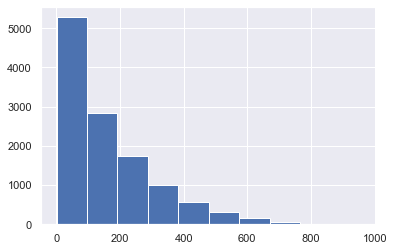

In [44]:
train['cnt'].hist()

In [152]:
from scipy import stats
z = np.abs(stats.zscore(train['cnt']))
print(z)

0        0.941926
1        0.783391
2        0.836236
3        0.961742
4        1.041010
           ...   
11994    0.531124
11995    0.075337
11996    0.188887
11997    0.400266
11998    0.611646
Name: cnt, Length: 11999, dtype: float64


In [155]:
threshold=3
print(np.where(z>3))

(array([ 3883,  5536,  5564,  5742,  6843,  6867,  7010, 10358, 10359,
       10382, 10383, 10397, 10406, 10407, 10421, 10430, 10431, 10473,
       10474, 10475, 10476, 10477, 10478, 10526, 10527, 10550, 10551,
       10574, 10575, 10589, 10598, 10599, 10613, 10622, 10623, 10624,
       10685, 10694, 10695, 10718, 10719, 10733, 10743, 10757, 10766,
       10767, 10809, 10810, 10861, 10862, 10885, 10886, 10900, 10909,
       10910, 10924, 10933, 10934, 10957, 10977, 10979, 10980, 11020,
       11029, 11030, 11044, 11053, 11054, 11091, 11100, 11124, 11125,
       11143, 11144, 11145, 11146, 11167, 11168, 11169, 11170, 11171,
       11172, 11196, 11197, 11211, 11220, 11221, 11259, 11268, 11269,
       11283, 11292, 11293, 11311, 11312, 11314, 11315, 11388, 11389,
       11403, 11412, 11413, 11436, 11437, 11460, 11461, 11505, 11532,
       11533, 11556, 11557, 11571, 11580, 11581, 11595, 11604, 11605,
       11619, 11628, 11629, 11691, 11700, 11701, 11715, 11724, 11725,
       11739, 11748

5. Seleccionamos la variables de entrada y las variables de salida

In [8]:
train_target = train['cnt']

train_feature = train.drop(['cnt'], axis=1)
train_target.shape, train_feature.shape

((11999,), (11999, 12))

6. Separamos la data para entrenar y otra parte para validar

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(train_feature, train_target, test_size=0.15, random_state=42)

In [10]:
X_train.shape, X_validation.shape

((10199, 12), (1800, 12))

7. Creamos el modelo de decisión con gradiente y boosting

In [62]:
model = XGBRegressor(gpu_id=0)

7.1 Hyperparameter tunning

In [86]:
from sklearn.model_selection import GridSearchCV
xgbr = XGBRegressor(gpu_id = 0, learning_rate=0.3, max_depth=6, n_estimators=100, subsample = 0.8)

In [90]:
tuned_parameters = {
    'max_depth' : [3,4,5,6],
    'min_child_weight' : [1,2,3,4,5,6],
    'learning_rate' : [0.01,0.05,0.1,0.2, 0.3],
}

In [91]:
clf = GridSearchCV(xgbr, param_grid=tuned_parameters, scoring = 'neg_root_mean_squared_error', cv=5)

In [92]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=0, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.3, max_bin=None,
                                    max_cat_to_...
                                    max_depth=6, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 6],
                         'min_child_weight': [1, 2, 3, 4, 5, 6]},
             scoring='neg_root_mean_squared_error')

In [93]:
print(clf.best_params_)

{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1}


In [94]:
print(clf.best_score_)

-56.512660288338466


8. Entrenamos el modelo

In [132]:
model = XGBRegressor(gpu_id = 0, learning_rate=0.1, max_depth=6, n_estimators=1000, subsample = 0.8, min_child_weight = 1, n_jobs = -1)

In [133]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

9. Observamos que variables le tomó más importancia el modelo

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

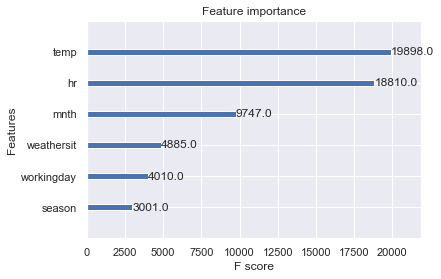

In [134]:
xgb.plot_importance(model, ax=plt.gca())

9. Evaluar las relaciones 

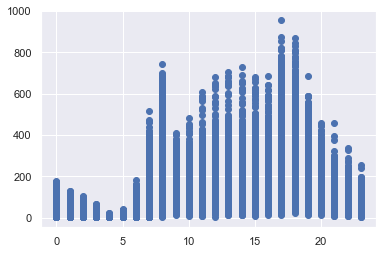

In [65]:
plt.scatter(train_feature['hr'], train_target)

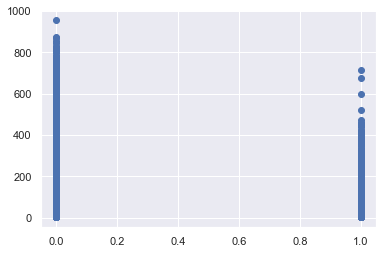

In [21]:
plt.scatter(train_feature['holiday'], train_target)

10. Evaluar el poder de predicción del modelo

In [135]:
predictions = model.predict(X_validation)

In [136]:
predictions[1:10]

array([  8.55393 , 545.17426 ,  55.957485, 161.18341 , 157.13916 ,
       389.04953 ,  90.303764, 119.65874 ,  49.680264], dtype=float32)

In [137]:
X_validation.iloc[0]

season         2.00
mnth           3.00
hr            10.00
workingday     0.00
weathersit     1.00
temp           0.26
Name: 1935, dtype: float64

In [138]:
y_validation.iloc[0]

125

11. Medimos el error

In [140]:
pred_train = model.predict(X_train)

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

In [141]:
print(r2_score(y_train, pred_train)) # Cuanta varianza en el modelo explica, es decir puedo explicar 97.89 % de todos los datos

0.9412433702400061


In [142]:
print(mean_squared_error(y_train, pred_train, squared=False))

36.68016043439882


12. Error en la validación

In [143]:
pred_validation = model.predict(X_validation)

In [144]:
print(r2_score(y_validation, predictions))

0.8470436419927806


In [145]:
print(mean_squared_error(y_validation, predictions, squared=False))

59.345105227966954


12.1 Ver la relación entre los datos reales y la predicción

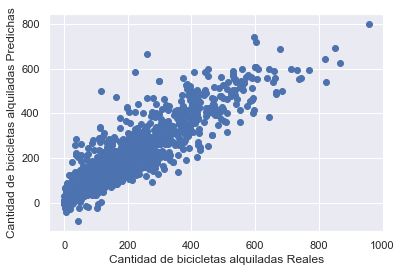

In [131]:
plt.scatter(y_validation, predictions)
plt.xlabel("Cantidad de bicicletas alquiladas Reales")
plt.ylabel("Cantidad de bicicletas alquiladas Predichas")
plt.show()

13. Obtenemos las predicciones respecto al archivo test

In [146]:
pred = model.predict(test.drop(['yr', 'holiday', 'weekday','atemp', 'hum', 'windspeed'], axis=1))

In [147]:
pred

array([ 7.6618342,  7.587709 , 25.973406 , ..., 71.3029   , 58.530468 ,
       37.44212  ], dtype=float32)

In [148]:
pred[0:10]

array([  7.6618342,   7.587709 ,  25.973406 ,  80.95657  , 177.80031  ,
       221.42416  , 367.51334  , 453.13388  , 463.9318   , 586.0616   ],
      dtype=float32)

In [149]:
pred = pd.DataFrame(pred, columns = ['pred'])

In [151]:
pred.to_csv('TeffaHM.csv', header=True, index=False)

Random Forest Regression

In [156]:
from sklearn.ensemble import RandomForestRegressor

In [157]:
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)

In [158]:
regressor.fit(X_train, y_train) 

RandomForestRegressor(random_state=0)

In [159]:
predicciones= regressor.predict(X_validation)

In [160]:
predicciones[0:10]

array([167.8375    ,   6.32901587, 442.17804762,  53.90433333,
       122.36916667, 132.29      , 388.29990476, 150.415     ,
       143.54133333,  49.88333333])

In [161]:
print(mean_squared_error(y_validation, predicciones, squared=False))

62.14076152337826


In [162]:
pred_rfr_01 = regressor.predict(test.drop(['yr', 'holiday', 'weekday','atemp', 'hum', 'windspeed'], axis=1))

In [163]:
pred_rfr_01 

array([12.305     ,  7.66944444, 22.54542857, ..., 81.89445238,
       56.7975    , 29.08183333])

In [164]:
pred_rfr_01= pd.DataFrame(pred_rfr_01 , columns = ['pred'])

In [170]:
pred_rfr_01 = np.round(pred_rfr_01,2)

In [171]:
pred_rfr_01

,pred
0,12.30
1,7.67
2,22.55
3,47.49
4,146.85
...,...
5375,145.61
5376,102.71
5377,81.89
5378,56.80


In [172]:
pred_rfr_01.to_csv('TeffaHM_v5.csv', header=True, index=False)

In [173]:
parameters = {'n_estimators':[100, 150, 250, 300], 'max_features':['sqrt', 'log2'], 'max_depth':[20, 30, 40]}

In [176]:
rfr_02 = GridSearchCV(estimator = regressor, param_grid = parameters, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [177]:
rfr_02.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [178]:
rfr_02.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=300,
                      random_state=0)

In [179]:
rfr_02.best_score_

-61.41354632184813

In [180]:
predicciones_rfr_02 = rfr_02.predict(X_validation)

In [181]:
predicciones_rfr_02

array([129.15972222,  13.02887108, 401.13746032, ..., 232.60983431,
       160.19301587,  24.02822222])

In [184]:
pred_rfr_02 = rfr_02.predict(test.drop(['yr', 'holiday', 'weekday','atemp', 'hum', 'windspeed'], axis=1))
pred_rfr_02= pd.DataFrame(pred_rfr_02 , columns = ['pred'])
pred_rfr_02 = np.round(pred_rfr_02,2)
pred_rfr_02.to_csv('TeffaHM.csv', header=True, index=False)

In [189]:
parameters_01 = {'n_estimators':[100, 150, 250, 300, 500], 'max_features':['sqrt', 'log2'], 'max_depth':[6,10,20, 30, 40]}

In [191]:
rfr_03 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = parameters_01, refit = True, verbose = 2, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)

In [196]:
rfr_03.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 10, 20, 30, 40],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 150, 250, 300, 500]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [197]:
rfr_03.best_estimator_

RandomForestRegressor(max_depth=20, max_features='log2', n_estimators=500)

In [198]:
rfr_03.best_score_

-61.41086501227826

In [ ]:
pred_rfr_03 = rfr_03.predict(test.drop(['yr', 'holiday', 'weekday','atemp', 'hum', 'windspeed'], axis=1))
pred_rfr_03= pd.DataFrame(pred_rfr_03 , columns = ['pred'])
pred_rfr_03 = np.round(pred_rfr_03,2)
pred_rfr_03.to_csv('TeffaHM.csv', header=True, index=False)